In [145]:
#import pandas as pd
#import sagemaker
data = pd.read_csv("model_dataset_full.csv")


In [146]:
data.size

95439300

In [124]:

import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()
role = get_execution_role()
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

In [148]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    ys = np.array(data["isFraud"]).astype("float32")
    
#    ys -= 1
        
#    drop_list = ["isFraud","nameOrig", "nameDest", "newbalanceOrig" , "oldbalanceDest", "newbalanceDest", "type_DEBIT"]
    drop_list = ["isFraud","nameOrig", "nameDest"]
    
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")
    
    np.random.seed(0)

    train_features, test_features, train_labels, test_labels = train_test_split(
    xs, ys, test_size=0.2)
    
    val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels
     
    
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(data)

In [151]:
train_features.size

61081152

In [150]:
val_features.size

7635144

In [129]:
test_features.size

1600000

In [144]:
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
binary_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.4xlarge',
                                               predictor_type='binary_classifier')

#binary_estimator.set_hyperparameters(feature_dim=8,
#                           predictor_type='binary_classifier',
#                           mini_batch_size=200)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


In [152]:
train_records = binary_estimator.record_set(train_features, train_labels, channel='train')
val_records = binary_estimator.record_set(val_features, val_labels, channel='validation')
test_records = binary_estimator.record_set(test_features, test_labels, channel='test')

In [ ]:
binary_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker:Creating training-job with name: linear-learner-2019-03-20-21-57-04-360


2019-03-20 21:57:04 Starting - Starting the training job...
2019-03-20 21:57:08 Starting - Launching requested ML instances......
2019-03-20 21:58:13 Starting - Preparing the instances for training......
2019-03-20 21:59:26 Downloading - Downloading input data...
2019-03-20 21:59:50 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[03/20/2019 21:59:52 INFO 140437431473984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'

In [156]:
binary_predictor3 = binary_estimator.deploy(initial_instance_count=1, 
                                                                     instance_type='ml.m4.xlarge', endpoint_name="linear-learner-full")

INFO:sagemaker:Creating model with name: linear-learner-2019-03-21-01-37-59-984
INFO:sagemaker:Creating endpoint with name linear-learner-full


---------------------------------------------------------------------------!

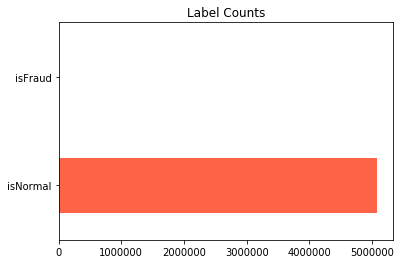

In [154]:
%matplotlib inline

# assign label names and count label frequencies

label_map = {0:'isNormal', 1:'isFraud'}
label_counts = pd.DataFrame(data=train_labels)[0].map(label_map).value_counts(sort=False).sort_index(ascending=False)
label_counts.plot('barh', color='tomato', title='Label Counts')

In [ ]:

import seaborn as sns

def evaluate_metrics(test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    test_preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.999


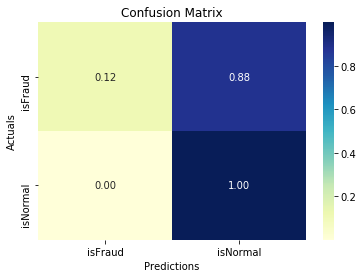

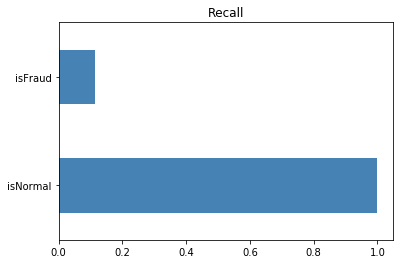

In [103]:
evaluate_metrics(binary_predictor, test_features, test_labels)

Accuracy: 0.999


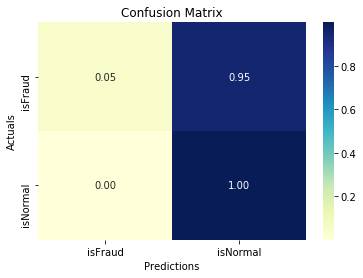

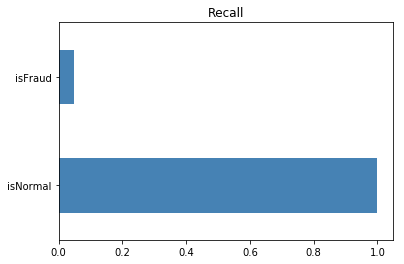

In [118]:
evaluate_metrics(binary_predictor2, test_features, test_labels)

Accuracy: 0.999


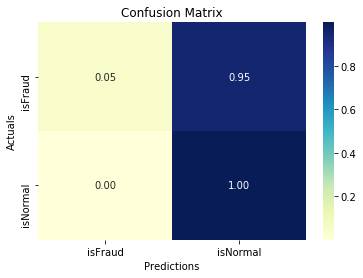

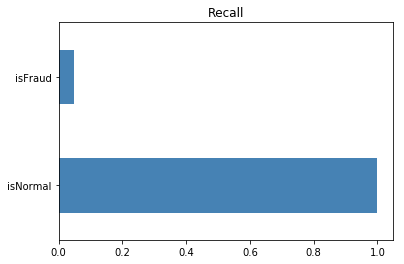

In [135]:
evaluate_metrics(binary_predictor3, test_features, test_labels)

In [ ]:
evaluate_metrics(binary_predictor3, test_features, test_labels)